# Silicon: The hello world of plane-wave DFT

This notebook is adapted from the DFTK tutorial (https://docs.dftk.org/stable/guide/tutorial/).

In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__, ".."))
using AtomsIO
using PseudoPotentialData
using DFTK
using Plots

  Activating project at `~/git/tutorial-cecam-workshop-dftk-2025`


In [2]:
system = load_system("Si_diamond.extxyz")

Atoms(Si₂, periodicity = TTT):
    cell_vectors      : [       0     2.73     2.73;
                             2.73        0     2.73;
                             2.73     2.73        0]u"Å"

    AtomView(Si, [       0,        0,        0]u"Å")
    AtomView(Si, [   1.365,    1.365,    1.365]u"Å")


In [3]:
functionals = PBE()
pseudopotentials = PseudoFamily("dojo.nc.sr.pbe.v0_4_1.standard.upf")
temperature = 1e-3
model = model_DFT(system; pseudopotentials, functionals, temperature)

Ecut = recommended_cutoff(model).Ecut
kgrid = (4, 4, 4)

basis = PlaneWaveBasis(model; Ecut, kgrid)

PlaneWaveBasis discretization:
    architecture         : DFTK.CPU()
    num. mpi processes   : 1
    num. julia threads   : 1
    num. DFTK  threads   : 1
    num. blas  threads   : 6
    num. fft   threads   : 1

    Ecut                 : 18.0 Ha
    fft_size             : (32, 32, 32), 32768 total points
    kgrid                : MonkhorstPack([4, 4, 4])
    num.   red. kpoints  : 64
    num. irred. kpoints  : 8

    Discretized Model(gga_x_pbe+gga_c_pbe, 3D):
        lattice (in Bohr)    : [0         , 5.15895   , 5.15895   ]
                               [5.15895   , 0         , 5.15895   ]
                               [5.15895   , 5.15895   , 0         ]
        unit cell volume     : 274.61 Bohr³
    
        atoms                : Si₂
        pseudopot. family    : PseudoFamily("dojo.nc.sr.pbe.v0_4_1.standard.upf")
    
        num. electrons       : 8
        spin polarization    : none
        temperature          : 0.001 Ha
        smearing             : DFTK.Smearing.F

In [4]:
scfres = self_consistent_field(basis; tol=1e-5);

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.453389954423                   -0.94    6.1    4.25s
  2   -8.455371774697       -2.70       -1.41    1.0    2.53s
  3   -8.455737131075       -3.44       -2.74    1.9    267ms
  4   -8.455761532199       -4.61       -3.18    3.6    225ms
  5   -8.455761718275       -6.73       -3.54    2.0    551ms
  6   -8.455761746665       -7.55       -4.70    1.4    188ms
  7   -8.455761750211       -8.45       -4.96    3.5    301ms
  8   -8.455761750266      -10.26       -5.87    1.5    231ms


In [5]:
scfres.energies

Energy breakdown (in Ha):
    Kinetic             3.0709072 
    AtomicLocal         -2.3422248
    AtomicNonlocal      1.1461496 
    Ewald               -8.3533209
    PspCorrection       0.5443635 
    Hartree             0.5666613 
    Xc                  -3.0882977
    Entropy             -0.0000000

    total               -8.455761750266

In [6]:
@show size(scfres.ρ)  # (fft_size..., num_spin)
@show size(scfres.ψ)  # (num_irred_kpoints,)
@show [size(ψk) for ψk in scfres.ψ]; # num_planewaves_at_kpoint × num_orbitals

size(scfres.ρ) = (32, 32, 32, 1)
size(scfres.ψ) = (8,)
[size(ψk) for ψk = scfres.ψ] = [(965, 9), (989, 9), (1008, 9), (998, 9), (1008, 9), (1003, 9), (998, 9), (992, 9)]


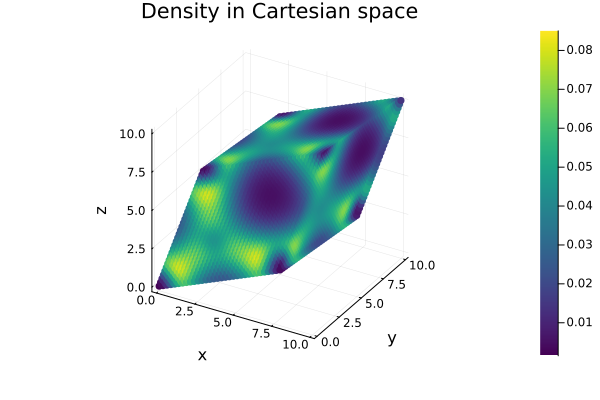

In [7]:
r_cart = DFTK.r_vectors_cart(scfres.basis)
plt = plot(title="Density in Cartesian space")
for z_idx in 1:(basis.fft_size[3])
    r_flat = reshape(r_cart[:, :, z_idx], :)
    ρ_flat = reshape(scfres.ρ[:, :, z_idx, 1], :)
    scatter!(
        plt,
        getindex.(r_flat, 1),
        getindex.(r_flat, 2),
        getindex.(r_flat, 3),
        marker_z=ρ_flat,
        colormap=:viridis,
        label=nothing,
        markerstrokewidth=0,
        xlabel="x",
        ylabel="y",
        zlabel="z",
    )
end
plt